# Experiments CNN and HAM10000

To avoid further confusion by libraries' dependency, we resized the image's height from 450 and width from 600 to 300 and 300 pixels, respectively.

In [39]:
%load_ext autoreload
%autoreload 2

import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import torch # Due to keras version
import tensorflow as tf
import imageprocessing
from imageprocessing import ImageResize, MaskedImage
import kerasmodels
from kerasmodels import CreateGenerator
import attacks
import preprocess_ham
from skincolors import IndividualTypologyAngle
from distance import DistanceMeasure

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Load

In [40]:
db = "HAM"
root = f"../../dataset/IEEE/{db}/"

train_df = pd.read_csv(f"{root}exp/train_df.csv")
valid_df = pd.read_csv(f"{root}exp/valid_df.csv")
test_df = pd.read_csv(f"{root}exp/test_df.csv")

In [41]:
train_df["labels"] = train_df["labels"].astype(str)
valid_df["labels"] = valid_df["labels"].astype(str)
test_df["labels"] = test_df["labels"].astype(str)

## Create Image Generator

In [42]:
sample_image_path = train_df["filepath"].iloc[0]
img_size = imageprocessing.get_image_size(sample_image_path)
print("H*W: ", img_size)

H*W:  (300, 300)


In [43]:
batch_size=8
img_size = img_size
cg = CreateGenerator(img_size, batch_size)
train_gen = cg.train_generator(train_df)
valid_gen = cg.valid_generator(valid_df)
test_gen = cg.valid_generator(test_df)

Found 2000 validated image filenames belonging to 2 classes.
Found 1563 validated image filenames belonging to 2 classes.
Found 1564 validated image filenames belonging to 2 classes.


## Training

Epoch 1/20


/home/kuniko/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.7126 - loss: 0.5865 - val_accuracy: 0.8407 - val_loss: 0.4025
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.7545 - loss: 0.5096 - val_accuracy: 0.8439 - val_loss: 0.3792
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.8037 - loss: 0.4226 - val_accuracy: 0.7569 - val_loss: 0.5259
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.7924 - loss: 0.4377 - val_accuracy: 0.7262 - val_loss: 0.5848
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.7812 - loss: 0.4477 - val_accuracy: 0.7889 - val_loss: 0.4452
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - accuracy: 0.7745 - loss: 0.4479 - val_accuracy: 0.7671 - val_loss: 0.5300
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.8019 - loss: 0.4207 - val_accuracy: 0.7684 - val_loss: 0.5293
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.7982 - loss: 0.4370 - val_accurac

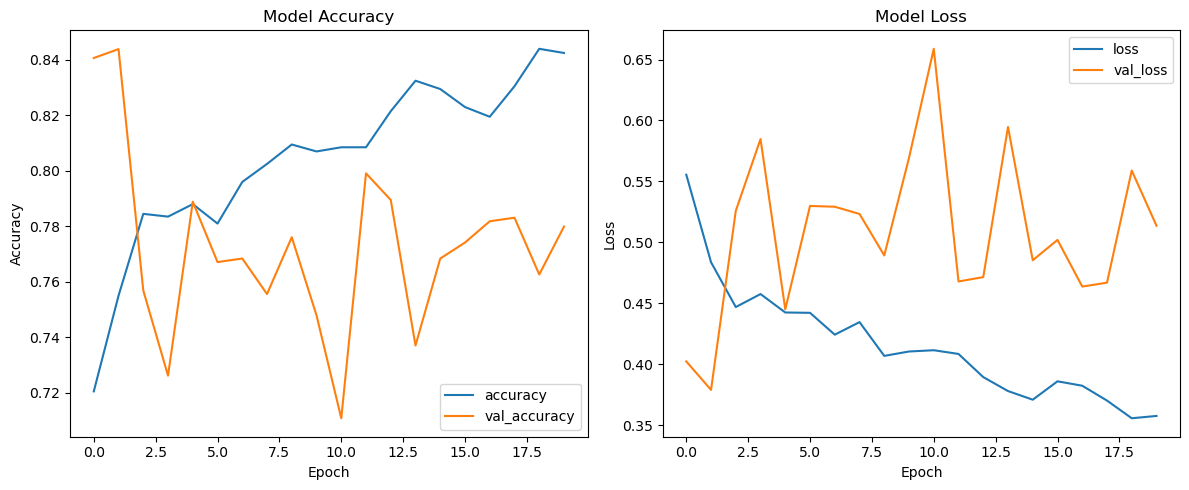

In [44]:
import keras
keras.utils.set_random_seed(42)

epochs = 20
patience = 5
start_from_epoch = 5
callback = tf.keras.callbacks.EarlyStopping(patience=patience, start_from_epoch=start_from_epoch, restore_best_weights=True)

learning_rate=0.00001
model = kerasmodels.make_cnn_model(learning_rate)
history = model.fit(train_gen, epochs=epochs, validation_data=valid_gen, callbacks=[callback])
kerasmodels.plot_training_results(history)

## Evaluation

In [45]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Loss", test_loss)
print("Test Accuracy", test_acc)
pred = model.predict(test_gen, verbose=0)
pred_class = ["1" if p[0] >= 0.5 else "0" for p in pred]

196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8040 - loss: 0.4157
Test Loss 0.4280201196670532
Test Accuracy 0.7915601134300232


In [46]:
test_df["pred"] = pred_class
print(classification_report(test_df["labels"], test_df["pred"]))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      1341
           1       0.39      0.78      0.52       223

    accuracy                           0.79      1564
   macro avg       0.67      0.79      0.69      1564
weighted avg       0.88      0.79      0.82      1564



In [47]:
# Save model
model.save(f"{root}exp/ham_cnn_model.keras")

# Adversarial Attacks

## Random Noise

True label: 0
Prediction: [[0.23038422]]
Prediction class: ['0']
Adversarial Prediction: [[1.]]
Adversarial Predicted Class: ['1']


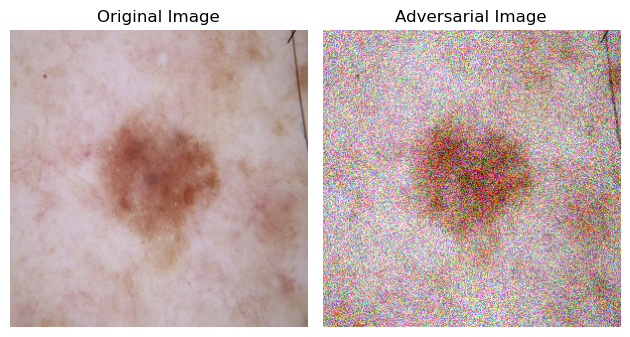

In [48]:
np.random.seed(33)
filepath = f"{root}data/ISIC_0030733.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.3
attacks.random_noise_attack_with_image(model, filepath, true_label, eps)

In [49]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.random_noise_attack(model, d["filepath"], d["labels"], eps))

In [50]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["RN pred"] = adv_pred
test_df["RN pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "RN")

RN Success rate: 0.6381074168797954
RN FP Success rate: 0.6342710997442456
RN FN Success rate: 0.0038363171355498722


## FGSM

True label: 0
Prediction: [[0.23038422]]
Prediction class: ['0']
Adversarial Prediction: [[0.99201655]]
Adversarial Predicted Class: ['1']


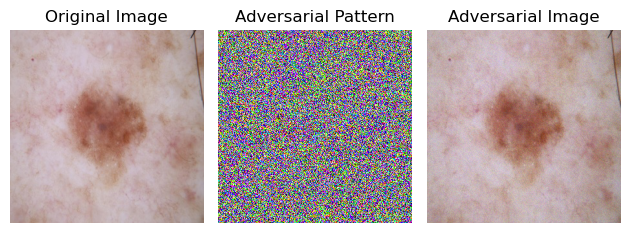

In [51]:
filepath = f"{root}data/ISIC_0030733.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.03
adv = attacks.fgsm_attack_with_image(model, filepath, true_label, eps)

In [52]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.fgsm_attack(model, d["filepath"], d["labels"], eps))

In [53]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["FGSM pred"] = adv_pred
test_df["FGSM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "FGSM")

FGSM Success rate: 0.4309462915601023
FGSM FP Success rate: 0.32289002557544755
FGSM FN Success rate: 0.10805626598465473


## Saliency Map Attack

True label: 0
Prediction: [[0.23038422]]
Prediction class: ['0']
Adversarial Prediction: [[0.99991107]]
Adversarial Predicted Class: ['1']


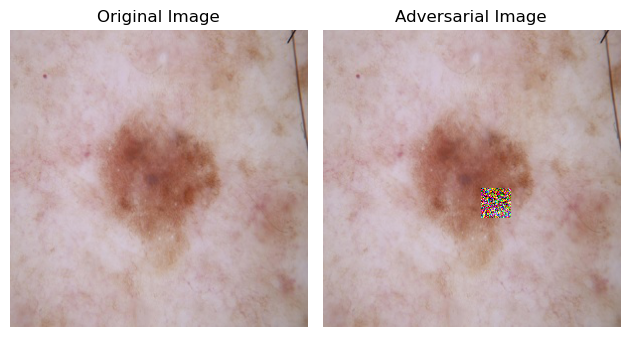

In [54]:
filepath = f"{root}data/ISIC_0030733.jpg"
true_label = test_df[test_df["filepath"] == filepath]["labels"].values[0]

eps = 0.8
patch_size=30
attacks.sailency_attack_with_image(model, filepath, true_label, eps, patch_size)

In [55]:
res = []
for i, d in test_df.iterrows():
    res.append(attacks.saliency_attack(model, d["filepath"], d["labels"], eps, patch_size))

In [56]:
adv_pred = [r[0].item() for r in res]
adv_class = [r[1][0] for r in res]

test_df["SM pred"] = adv_pred
test_df["SM pred class"] = adv_class

test_df = attacks.attack_success_rate(test_df, "SM")

SM Success rate: 0.33951406649616367
SM FP Success rate: 0.3235294117647059
SM FN Success rate: 0.0159846547314578


## Data export for analysis

In [57]:
test_df.to_csv(f"{root}exp/test_df_HAM10000_CNN.csv", index=False)